In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
warnings.filterwarnings("ignore")


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels = portfolioGeneration.getUniqueModels(allModels)
    for model in uniqueModels:
        print(model.describe())
    return uniqueModels

In [3]:
tickerToTrade = "EWT"

In [4]:
uniqueModels = getUniqueModelsForTicker(tickerToTrade)

***ORIGINAL MODELS***
((10, ('IEF', 3, None, None), 3, 'EWT'), 10, 250)
((10, ('EWH', 5, None, 10), 3, 'EWT'), 10, 100)
((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)
((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
***UNIQUE MODELS***
((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)


In [9]:
def computeReturnsForUniqueModels(uniqueModels, factorToTrade):
    tickersRequired = []
    tickersTraded = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
        if mod.inputSeries.series.ticker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.series.ticker)
        if mod.inputSeries.targetTicker not in tickersTraded:
            tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    modelReturns, modelPredictions = portfolioGeneration.generateAllReturns(uniqueModels, joinedData)
    
    return modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)), joinedData

In [10]:
factorToTrade = "SPY"
modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModels(uniqueModels, factorToTrade)

((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)
EWT
IEF
EWH
SPY
((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
THREAD  2 PROGRESS: 0.5660377358490566
THREAD  1 PROGRESS: 0.5660377358490566
THREAD  5 PROGRESS: 0.5660377358490566
THREAD  0 PROGRESS: 0.5660377358490566
THREAD  4 PROGRESS: 0.5660377358490566
THREAD  3 PROGRESS: 0.5660377358490566
THREAD  6 PROGRESS: 0.5660377358490566
THREAD  7 PROGRESS: 0.5660377358490566
THREAD  8 PROGRESS: 0.5660377358490566
THREAD  11 PROGRESS: 0.5769230769230769
THREAD  10 PROGRESS: 0.5769230769230769
THREAD  12 PROGRESS: 0.5769230769230769
THREAD  13 PROGRESS: 0.5769230769230769
THREAD  9 PROGRESS: 0.5769230769230769
THREAD  15 PROGRESS: 0.5769230769230769
THREAD  14 PROGRESS: 0.5769230769230769
THREAD  16 PROGRESS: 0.5769230769230769
THREAD  17 PROGRESS: 0.5769230769230769
THREAD  21 PROGRESS: 0.5769230769230769
THREAD  18 PROGRESS: 0.5769230769230769
THREAD  19 PROGRESS: 0.5769230769230769
THREAD  2

,"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)","((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)",Factor Return
"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)",1.000000,-0.037648,0.029821
"((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)",-0.037648,1.000000,-0.122131
Factor Return,0.029821,-0.122131,1.000000


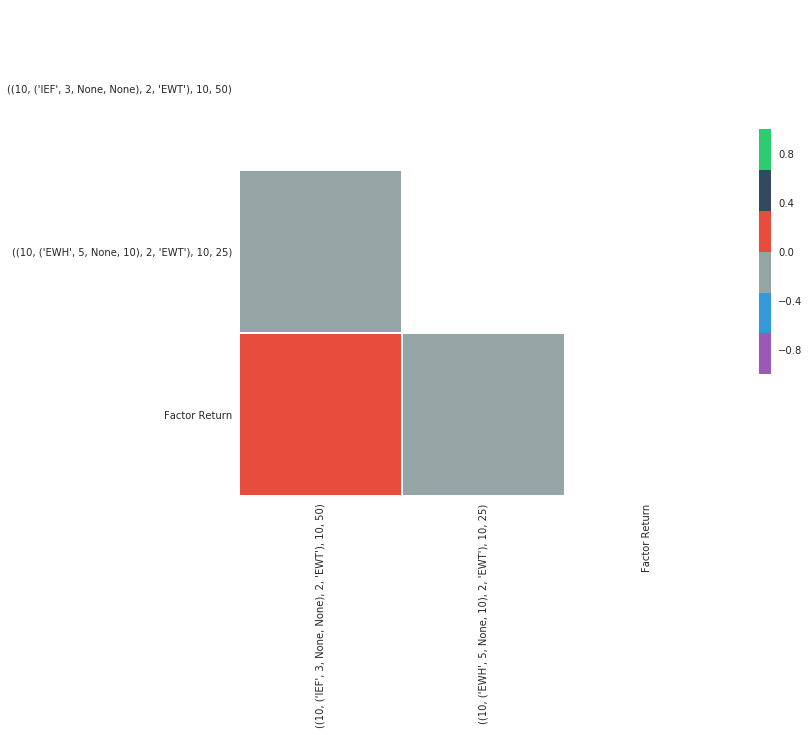

,"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)","((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)",Factor Return
"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)",0.000134,-0.000006,0.000004
"((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)",-0.000006,0.000194,-0.000021
Factor Return,0.000004,-0.000021,0.000146


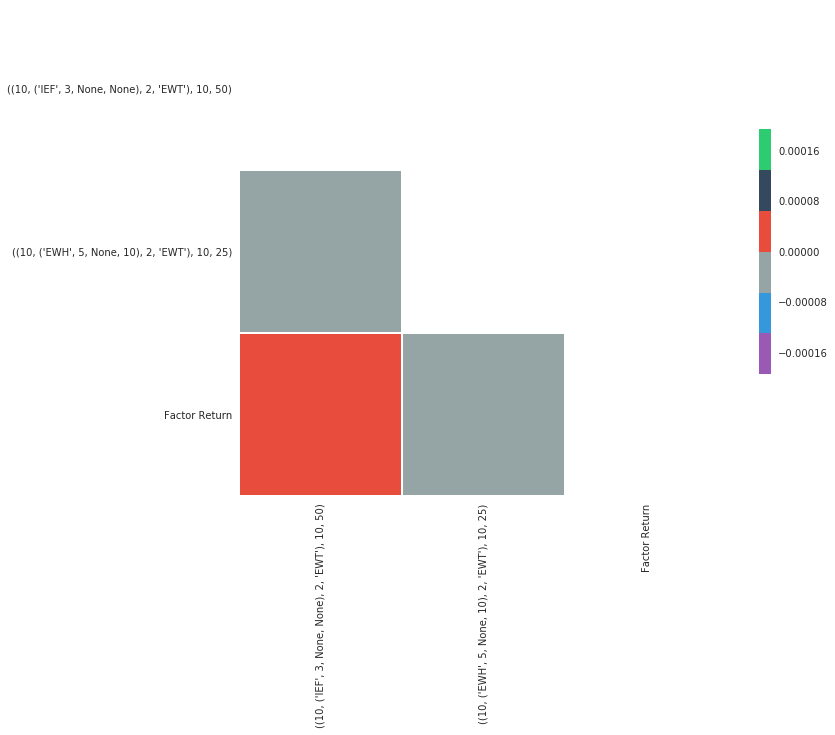

In [11]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [12]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)


In [13]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="Just trade underlying vs SPY", benchmark=factorToTrade)

PORTFOLIO HASH: 6258238755a1b74f251d1455565b494a05fec30eba348b8a17101c42
a762825ed2a3e080b702b24d23121d77b9e6b6fe24af40f5d3187f44
b903708f9b21d044698db01d68f6be915739a688f28c591eb57807c3


In [29]:
import importlib
importlib.reload(portfolioGeneration)

<module 'portfolioGeneration' from '/home/prohb125/walkforwardTrader/portfolioGeneration.py'>

In [22]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)

In [23]:
allModels = portfolio.getModelsByKey(modelHashes)

In [26]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)

In [27]:
hrpReturns, historicalWeights = portfolioGeneration.\
    produceHRPPredictions(aggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
    22, startIndex=None, maxWindowSize=True)
print("COMPUTED HISTORICAL WEIGHTS")
portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                allModels, historicalWeights, aggregatePredictions)

COMPUTED HISTORICAL WEIGHTS


In [ ]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)

{'key': '6258238755a1b74f251d1455565b494a05fec30eba348b8a17101c42', 'description': 'Just trade underlying vs SPY', 'benchmark': 'SPY'}
((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)
((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
EWT
SPY
